# IBM Applied Data Science Capstone Project
## Geographical Expansion Options for Coffee Shop Owners in Marlow, UK
This notebook will be used to drive the above analysis and to provide supporting information the reports and presentation/blog for the capstone project of the Coursera IBM Applied Data Science specialisation. 

## Preparation
Let's start by getting all of the libraries that we need to perform the analysis

In [91]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # To retrieve the geocoding for Marlow.

import requests # an HTTP library that we'll use for accessing FourSquare

import folium # we'll use this to find towns within a radius of Marlow

import pandas as pd
import numpy as np

import matplotlib.colors as colors

Solving environment: ...working... done

# All requested packages already installed.



## 1. Selecting the candidate towns
We'll use Nominatim from GeoPy to find Marlow's latitude and longitude, then Folium to display the surrounding area to select the nearest ten towns.

In [92]:
geolocator = Nominatim(user_agent="foursquare_agent")
marlow_location = geolocator.geocode("Marlow, UK")
latitude = marlow_location.latitude
longitude = marlow_location.longitude

In [93]:
marlow_map = folium.Map( location=[latitude,longitude] , zoom_start = 11 )
folium.Marker([latitude, longitude]).add_to(marlow_map)
folium.Circle([latitude, longitude],radius=16000).add_to(marlow_map) # 16000m is roughly ten miles

marlow_map

Looking at the map, the following locations seem to be within a ten-mile radius of Marlow:

- Cookham
- Maidenhead
- Henley
- Twyford
- High Wycombe
- Beaconsfield
- Amersham
- Bourne End
- Gerrards Cross
- Slough
- Windsor
 
Let's create a Series containing these values as well as Marlow for comparison purposes.

In [4]:
candidate_locations = pd.DataFrame( [
    "Maidenhead" , 
    "Henley-on-Thames" , 
    "Twyford" , 
    "High Wycombe" , 
    "Beaconsfield" , 
    "Amersham" ,
    "Bourne End" ,
    "Gerrards Cross" ,
    "Slough" ,
    "Windsor" ,
    "Marlow"
] , columns = [ "Location" ] )
candidate_locations = candidate_locations.set_index( "Location" )
candidate_locations

""
Location
Maidenhead
Henley-on-Thames
Twyford
High Wycombe
Beaconsfield
Amersham
Bourne End
Gerrards Cross
Slough


### Importing Population Data
We need to find out the population for each of the above locations. We'll use the list of the 1000 most populous towns and cities in the UK on the [Geographist website](https://www.thegeographist.com/uk-cities-population-1000/). It's in an HTML table so we'll use pandas to import it.

In [94]:
# It's the first table on the page
population_table = pd.read_html( "https://www.thegeographist.com/uk-cities-population-1000/" )[0]
population_table.head()

,Rank,in region,City/Town,Ceremonial county,Unnamed: 4,Region,Population
0,1,1,London,London,NaN,London,8907918.0
1,2,1,Birmingham,West Midlands,NaN,West Midlands,1153717.0
2,3,1,Glasgow,Glasgow,NaN,Scotland,612040.0
3,4,1,Liverpool,Merseyside,NaN,North West,579256.0
4,5,1,Bristol,Bristol,NaN,South West,571922.0


Let's tidy this up.

In [95]:
population_table = population_table.drop( columns = [ "Rank" , "in region" , "Unnamed: 4"] )
population_table = population_table.set_index( "City/Town")
population_table.head()

,Ceremonial county,Region,Population
City/Town,,,
London,London,London,8907918.0
Birmingham,West Midlands,West Midlands,1153717.0
Glasgow,Glasgow,Scotland,612040.0
Liverpool,Merseyside,North West,579256.0
Bristol,Bristol,South West,571922.0


In [96]:
population_table.sort_values( by="Population" ).head()

,Ceremonial county,Region,Population
City/Town,,,
Horndean,Hampshire,South East,48.851
Newport,Gwent,Wales,133.353
Caister-on-Sea,Norfolk,East,8898.000
Peebles,Scottish Borders,Scotland,8940.000
Broughton Astley,Leicestershire,East Midlands,8950.000


Let's join our candidate locations with this population data.

In [97]:
candidate_locations.join( population_table , on="Location" , how="left" )

,Ceremonial county,Region,Population
Location,,,
Maidenhead,Berkshire,South East,67441.0
Henley-on-Thames,Oxfordshire,South East,11633.0
Twyford,NaN,NaN,NaN
High Wycombe,Buckinghamshire,South East,124073.0
Beaconsfield,Buckinghamshire,South East,14650.0
Amersham,Buckinghamshire,South East,24485.0
Bourne End,NaN,NaN,NaN
Gerrards Cross,NaN,NaN,NaN
Slough,Berkshire,South East,164046.0


As is often the case, data from different sources don't match perfectly and a quick check on those not in the list showed that Gerrards Cross is actually listed as "Gerrards CrossChalfont St Peter". Let's update that so that our data works.

In [98]:
population_table.rename( index = { "Gerrards CrossChalfont St Peter" : "Gerrards Cross" } , inplace = True )
candidate_with_populations = candidate_locations.join( population_table , on="Location" , how="left" )
candidate_with_populations

,Ceremonial county,Region,Population
Location,,,
Maidenhead,Berkshire,South East,67441.0
Henley-on-Thames,Oxfordshire,South East,11633.0
Twyford,NaN,NaN,NaN
High Wycombe,Buckinghamshire,South East,124073.0
Beaconsfield,Buckinghamshire,South East,14650.0
Amersham,Buckinghamshire,South East,24485.0
Bourne End,NaN,NaN,NaN
Gerrards Cross,Buckinghamshire,South East,21004.0
Slough,Berkshire,South East,164046.0


That's better! Let's remove the smaller locations on the basis that they wouldn't have enough potential customers to be attractive for our coffee shop owners.

In [99]:
candidate_with_populations = candidate_with_populations.dropna()
candidate_with_populations = candidate_with_populations.sort_values( by = "Population" , ascending = False )
candidate_with_populations

,Ceremonial county,Region,Population
Location,,,
Slough,Berkshire,South East,164046.0
High Wycombe,Buckinghamshire,South East,124073.0
Maidenhead,Berkshire,South East,67441.0
Windsor,Berkshire,South East,32207.0
Amersham,Buckinghamshire,South East,24485.0
Gerrards Cross,Buckinghamshire,South East,21004.0
Marlow,Buckinghamshire,South East,14839.0
Beaconsfield,Buckinghamshire,South East,14650.0
Henley-on-Thames,Oxfordshire,South East,11633.0


We seem to have quite a spread of populations. Let's plot them to get a visual representation.

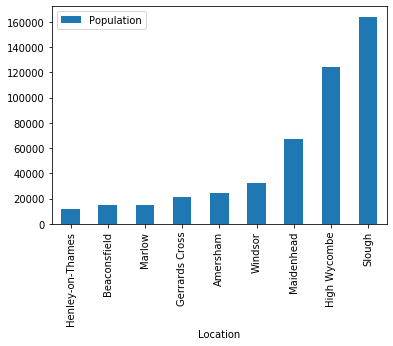

In [40]:
candidate_with_populations.sort_values( by="Population" ).plot.bar( y="Population" )

There appear to be two categories: small towns with populations less than 35000 and large towns with populations over 65000. The larger towns (Maidenhead, High Wycombe and Slough) may well have suburban areas with their own coffee shops that aren't getting picked up in this analysis as we're restricting the search radius for venues in FourSquare.

For the purposes of this analysis, we will focus on those smaller towns with a similar population to Marlow.

In [43]:
candidate_with_populations = candidate_with_populations.loc[ candidate_with_populations[ "Population" ] < 40000 ]
candidate_with_populations

,Ceremonial county,Region,Population
Location,,,
Henley-on-Thames,Oxfordshire,South East,11633.0
Beaconsfield,Buckinghamshire,South East,14650.0
Amersham,Buckinghamshire,South East,24485.0
Gerrards Cross,Buckinghamshire,South East,21004.0
Windsor,Berkshire,South East,32207.0
Marlow,Buckinghamshire,South East,14839.0


There are a number of towns in the UK with the same names so it's a good sanity check to see that all locations are in the South East and are either in the same county as Marlow (Buckinghamshire) or those surrounding it.

### Adding coffee shop information to our candidate locations
The first thing to do is to geocode each of the candidate locations so that we can feed them into FourSquare.

In [12]:
def geocode( row ):
    location = row.name
    geocoded_location = geolocator.geocode( location )
    return pd.Series( [ geocoded_location.longitude , geocoded_location.latitude ] )

In [44]:
location_info = candidate_with_populations.apply( geocode , axis = 1 )
location_info.columns = [ "Longitude" , "Latitude" ]
candidates_full = candidate_with_populations.join( location_info )
candidates_full

,Ceremonial county,Region,Population,Longitude,Latitude
Location,,,,,
Henley-on-Thames,Oxfordshire,South East,11633.0,-0.905029,51.537579
Beaconsfield,Buckinghamshire,South East,14650.0,-0.657123,51.608288
Amersham,Buckinghamshire,South East,24485.0,-0.607364,51.674087
Gerrards Cross,Buckinghamshire,South East,21004.0,-0.561640,51.585218
Windsor,Berkshire,South East,32207.0,-0.604140,51.483798
Marlow,Buckinghamshire,South East,14839.0,12.572512,54.155649


Marlow's geolocation looks a bit out of kilter with the other towns. Let's add the county name to the look up to see what we get.

In [45]:
location = geolocator.geocode( "Marlow, Buckinghamshire" )
location

Location(Marlow, Buckinghamshire, South East, England, SL7 1DA, United Kingdom, (51.5718668, -0.77695, 0.0))

That looks to be more in line with the other towns. Let's update the candidates data accordingly.

In [46]:
candidates_full.loc[ "Marlow" , [ "Longitude" , "Latitude" ] ] = [ location.longitude , location.latitude ]
candidates_full.loc[ "Marlow" ]

Ceremonial county    Buckinghamshire
Region                    South East
Population                     14839
Longitude                   -0.77695
Latitude                     51.5719
Name: Marlow, dtype: object

Now that we have the correct geocoded location, let's get information about all the nearby coffee shops from FourSquare.

In [47]:
CLIENT_ID = 'AZKXH5PM02UGZGWNHWEPHVWEKAZ5RWSNRYBZNSSJT3EOBC2N' # your Foursquare ID
CLIENT_SECRET = 'XGWLP3PRPFSBGN0W534NRHRNNYT4IN5UT5QRJMBD4TAIOML5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [48]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&section={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            200, #limit to 100 venues
            "coffee", # choose the coffee section so that we pick up cafes, coffee shops and restaurants that serve coffee.
            1500) # look for venues within 1500m of two centre
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'], 
            venue['venue']['categories'][0]['name']) for venue in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
nearby_venues = getNearbyVenues( candidates_full.index , candidates_full["Latitude"] , candidates_full["Longitude"] )
nearby_venues.head( 15 )

,Town,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Henley-on-Thames,51.537579,-0.905029,Chocolate Theatre Cafe,51.536980,-0.901000,Café
1,Henley-on-Thames,51.537579,-0.905029,Spoon,51.536498,-0.903779,Café
2,Henley-on-Thames,51.537579,-0.905029,Costa Coffee,51.536940,-0.904009,Coffee Shop
3,Henley-on-Thames,51.537579,-0.905029,Hot Gossip,51.536387,-0.903455,Café
4,Henley-on-Thames,51.537579,-0.905029,Caffè Nero,51.538925,-0.904630,Coffee Shop
5,Henley-on-Thames,51.537579,-0.905029,Harris + Hoole,51.537537,-0.904585,Coffee Shop
6,Henley-on-Thames,51.537579,-0.905029,Patisserie Valerie,51.537618,-0.904931,Café
7,Henley-on-Thames,51.537579,-0.905029,Starbucks,51.537708,-0.904838,Coffee Shop
8,Beaconsfield,51.608288,-0.657123,Starbucks,51.609805,-0.642472,Coffee Shop
9,Beaconsfield,51.608288,-0.657123,Jungs,51.612849,-0.647444,Café


In [50]:
nearby_venues.shape

(64, 7)

So we have 64 venues in total across the 6 locations.

Lots of these coffee shops are part of large chains such as Costa, Starbucks and Caffe Nero. Let's mark those venues that belong to a chain.

In [51]:
nearby_venues[ "Chain" ] = nearby_venues[ "Venue" ].str.match( "Costa|Starbucks|.*Nero" )
nearby_venues.head()

,Town,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Chain
0,Henley-on-Thames,51.537579,-0.905029,Chocolate Theatre Cafe,51.536980,-0.901000,Café,False
1,Henley-on-Thames,51.537579,-0.905029,Spoon,51.536498,-0.903779,Café,False
2,Henley-on-Thames,51.537579,-0.905029,Costa Coffee,51.536940,-0.904009,Coffee Shop,True
3,Henley-on-Thames,51.537579,-0.905029,Hot Gossip,51.536387,-0.903455,Café,False
4,Henley-on-Thames,51.537579,-0.905029,Caffè Nero,51.538925,-0.904630,Coffee Shop,True


Let's plot Amersham's coffee shops using Folium.

In [52]:
def showTown( location , venues , zoomStart ):
    
    townMap = folium.Map( location = location , zoom_start = zoomStart )

    folium.Marker( location ).add_to( townMap )

    for lat, lon, poi in zip( venues[ 'Venue Latitude' ] , venues[ 'Venue Longitude' ] , amersham_venues[ 'Venue' ] ):
        label = poi
        folium.CircleMarker(
            [ lat , lon],
            radius=5,
            popup = folium.Popup( label , parse_html=True),
            color="blue",
            fill=True,
            fill_color = "blue",
            fill_opacity=0.7,
            parse_html = True).add_to( townMap )

    return townMap
    

In [63]:
showTown( 
    candidates_full.loc[ candidates_full.index == "Amersham" ,  [ "Latitude" , "Longitude" ] ].values.tolist()[ 0 ] , 
    nearby_venues.loc[ nearby_venues[ "Town" ] == "Amersham" ] ,
    14 )

Let's aggregate the venue count and chain venues by town and join that to our main candidates data.

In [64]:
grouped_by_town = nearby_venues.groupby( "Town" )
venues_by_town = grouped_by_town.agg( { "Venue" : [ "count" ] , "Chain" : [ "sum" ] } )
venues_by_town.columns = [ "Venue Count" , "Chain" ]

joined = pd.merge( candidates_full , venues_by_town , how="inner" , left_index= True , right_on = "Town" )
joined

,Ceremonial county,Region,Population,Longitude,Latitude,Venue Count,Chain
Town,,,,,,,
Henley-on-Thames,Oxfordshire,South East,11633.0,-0.905029,51.537579,8,3.0
Beaconsfield,Buckinghamshire,South East,14650.0,-0.657123,51.608288,6,2.0
Amersham,Buckinghamshire,South East,24485.0,-0.607364,51.674087,9,3.0
Gerrards Cross,Buckinghamshire,South East,21004.0,-0.561640,51.585218,6,2.0
Windsor,Berkshire,South East,32207.0,-0.604140,51.483798,28,7.0
Marlow,Buckinghamshire,South East,14839.0,-0.776950,51.571867,7,2.0


Let's plot population against venue count to see how the towns compare.

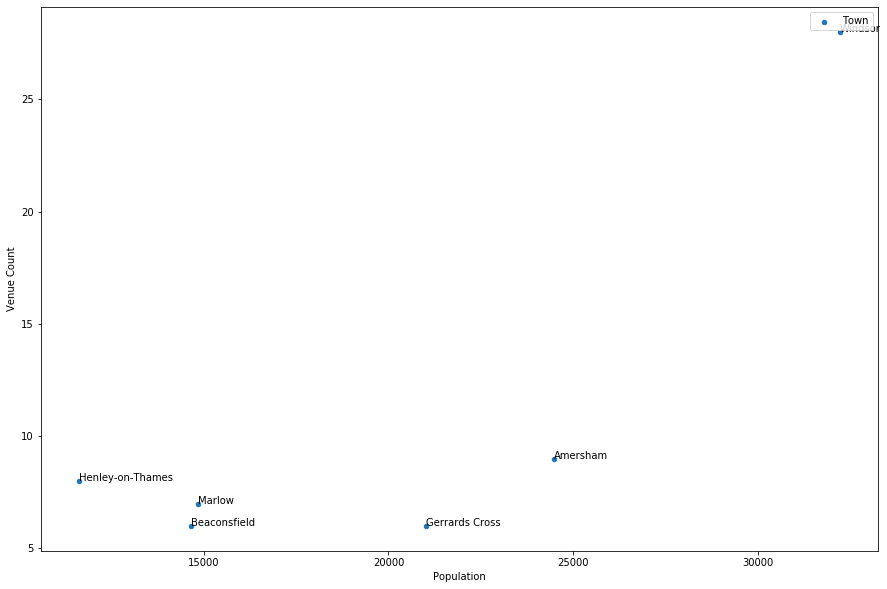

In [56]:
ax = joined.plot.scatter( x="Population" , y = "Venue Count" , label = "Town" , figsize=(15,10) )
for index , row in joined.iterrows():
    ax.annotate( row.name , ( row[ "Population" ] , row[ "Venue Count" ] ) )

Let's create a new stat that plots number of people per coffee shop in each town and plot that against 

In [66]:
joined.loc[ : , "People per Coffee Shop" ] = joined[ "Population" ] / joined[ "Venue Count" ]
joined

,Ceremonial county,Region,Population,Longitude,Latitude,Venue Count,Chain,People per Coffee Shop
Town,,,,,,,,
Henley-on-Thames,Oxfordshire,South East,11633.0,-0.905029,51.537579,8,3.0,1454.125000
Beaconsfield,Buckinghamshire,South East,14650.0,-0.657123,51.608288,6,2.0,2441.666667
Amersham,Buckinghamshire,South East,24485.0,-0.607364,51.674087,9,3.0,2720.555556
Gerrards Cross,Buckinghamshire,South East,21004.0,-0.561640,51.585218,6,2.0,3500.666667
Windsor,Berkshire,South East,32207.0,-0.604140,51.483798,28,7.0,1150.250000
Marlow,Buckinghamshire,South East,14839.0,-0.776950,51.571867,7,2.0,2119.857143


Let's plot that stat in a bar chart.

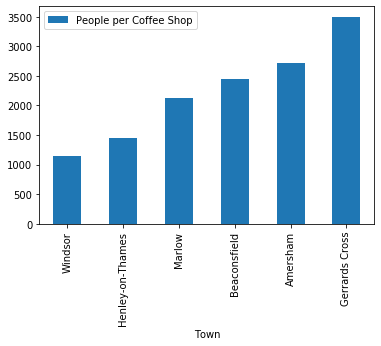

In [68]:
ax = joined.sort_values( by="People per Coffee Shop" ).plot.bar( y="People per Coffee Shop" )

Beaconsfield, Amersham and Gerrards Cross are similarly-sized small towns and have more people per coffee shop than Marlow.

What we haven't done is compared the number of independent (non-chain) coffee shops that exist in each of those towns to see whether that changes the relationship.

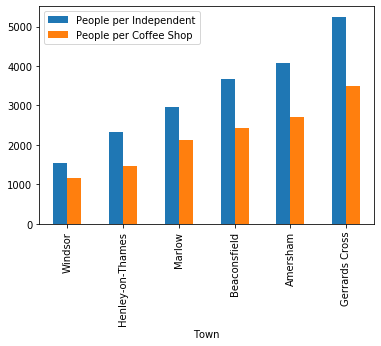

In [78]:
joined[ "Independents" ] = joined["Venue Count"] - joined[ "Chain" ]
joined[ "People per Independent" ] = joined[ "Population"] / joined[ "Independents" ]

ax = joined.sort_values( by="People per Independent" ).plot.bar( y=[ "People per Independent" , "People per Coffee Shop" ] )

How the town relate is almost exactly the same with Gerrards Cross being the least well serviced by coffee shops, both in total and independents.

Let's look at the numbers:

In [82]:
joined.sort_values( by="People per Independent" , ascending = False )

,Ceremonial county,Region,Population,Longitude,Latitude,Venue Count,Chain,People per Coffee Shop,People per Independent,Independents
Town,,,,,,,,,,
Gerrards Cross,Buckinghamshire,South East,21004.0,-0.561640,51.585218,6,2.0,3500.666667,5251.000000,4.0
Amersham,Buckinghamshire,South East,24485.0,-0.607364,51.674087,9,3.0,2720.555556,4080.833333,6.0
Beaconsfield,Buckinghamshire,South East,14650.0,-0.657123,51.608288,6,2.0,2441.666667,3662.500000,4.0
Marlow,Buckinghamshire,South East,14839.0,-0.776950,51.571867,7,2.0,2119.857143,2967.800000,5.0
Henley-on-Thames,Oxfordshire,South East,11633.0,-0.905029,51.537579,8,3.0,1454.125000,2326.600000,5.0
Windsor,Berkshire,South East,32207.0,-0.604140,51.483798,28,7.0,1150.250000,1533.666667,21.0


## Recommendations

My recommendation would be to consider, in descending order of preference, one of Gerrards Cross, Amersham and Beaconsfield as a viable options for geographical expansion. Each is less well served by its independent coffee shops than Marlow.